In [1]:
import os
import yaml
import copy
import pickle
import ml_collections
import wandb, signatory

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os import path as pt
from tqdm import tqdm
sns.set_style("darkgrid")  # 원하는 스타일 선택

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from src.utils import *
from src.evaluation.summary import full_evaluation

In [2]:
# Load configuration dict
config_dir = 'configs/config.yaml'
with open(config_dir) as file:
    config = ml_collections.ConfigDict(yaml.safe_load(file))

if (config.device == "cuda" and torch.cuda.is_available()):
    config.update({"device": "cuda:1"}, allow_val_change=True)
    torch.cuda.set_device(0)
else:
    config.update({"device": "cpu"}, allow_val_change=True)

set_seed(config.seed)

### Data Preprocess

In [3]:
def rolling_window(data, window_size):
    n_windows = data.shape[0] - window_size + 1
    windows = np.zeros((n_windows, window_size, data.shape[1]))
    for idx in range(n_windows):
        windows[idx] = data[idx:idx + window_size]
    return windows

# Step 1: Load and preprocess data
df = pd.read_csv(f"./data/{config.file_name}.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date', inplace=True)
df = df.apply(pd.to_numeric).astype(float)

# Step 2: Compute log returns
log_returns = np.diff(np.log(df), axis=0)
print(log_returns.shape)

# Step 3: Scale the log returns
log_returns_scaled, scalers = scaling(log_returns)

# Step 4: Prepare initial prices and create rolling windows
init_price = torch.from_numpy(np.array(df)[:-(config.n_steps), :]).float().unsqueeze(1)
log_returns_scaled = torch.from_numpy(rolling_window(log_returns_scaled, config.n_steps)).float()
print('init_price:', init_price.shape)
print('log_returns_scaled:', log_returns_scaled.shape)

(5720, 6)


/workspace/Task_Generation/QuantGAN_mvfit/src/preprocess/gaussianize.py:179: UserWarning: Warning: No convergence after 100 iterations. Increase max_iter.
  warnings.warn("Warning: No convergence after %d iterations. Increase max_iter." % max_iter)
/workspace/Task_Generation/QuantGAN_mvfit/src/preprocess/gaussianize.py:179: UserWarning: Warning: No convergence after 100 iterations. Increase max_iter.
  warnings.warn("Warning: No convergence after %d iterations. Increase max_iter." % max_iter)


init_price: torch.Size([5593, 1, 6])
log_returns_scaled: torch.Size([5593, 128, 6])


### Generative models for time series generation

### Data Construction

We divide the data into training and validation set for the offline evaluation of our model

In [4]:
perm_idx = torch.randperm(log_returns_scaled.shape[0])
train_size = int(0.7*log_returns_scaled.shape[0])

training_data = log_returns_scaled[perm_idx[:train_size]]
train_init_price = init_price[perm_idx[:train_size]]
test_data = log_returns_scaled[perm_idx[train_size:]]
test_init_price = init_price[perm_idx[train_size:]]

print("training_data: ", training_data.shape)
print("test_data: ", test_data.shape)

training_data:  torch.Size([3915, 128, 6])
test_data:  torch.Size([1678, 128, 6])


Load the dataset


In [5]:
training_set = TensorDataset(training_data)
test_set = TensorDataset(test_data)

train_dl = DataLoader(training_set, batch_size=config.batch_size, shuffle=True)
test_dl = DataLoader(test_set, batch_size=config.batch_size, shuffle=True)

### Generative model

Here we construct a generator and a discriminator for this task. Both the generator and discriminator takes as input the time series. Then we have the training algorithm TailGANTrainer.

### Initialize the generator, discriminator and the trainer

In [6]:
from src.baselines.networks.discriminators import UserDiscriminator
from src.baselines.networks.generators import UserGenerator
from src.baselines.trainer import *

generator = UserGenerator(config)
discriminator = UserDiscriminator(config)
trainer = GANTrainer(G=generator, D=discriminator, train_dl=train_dl, config=config)

### Model training and saving

In [7]:
# # Model training
#trainer.fit()

# Model Evaluation

### MVFIT-GAN

In [8]:
from scipy.stats import entropy, wasserstein_distance, ks_2samp, spearmanr, kendalltau
from statsmodels.tsa.stattools import acf
from scipy.spatial.distance import jensenshannon

full_name = "indices_300_256_G_lr_0.0002_D_lr_0.0001_noise_6_hidden_dim_120"

In [9]:
""" Find the best epochs based on 100 days cumulative distribution """
window = 100
gen_tmp = UserGenerator(config)
min_dist = float('inf')  
best_epoch = 0

def compute_avg_emd(real_data, fake_data, window):
    """
    Compute the Earth Mover's Distance (EMD) for real and fake data over a rolling window.
    """
    emd = 0
    for i in range(real_data.shape[1]):  # Iterate over features
        real_dist = rolling_window(real_data[:, i, :].T, window).sum(axis=1).ravel()
        fake_dist = rolling_window(fake_data[:, i, :].T, window).sum(axis=1).ravel()
        emd += wasserstein_distance(real_dist, fake_dist)
    return emd

batch_size = 1000
for epoch in range(50, 300, 5):
    
    # Load generator for the current epoch
    generator.load_state_dict(torch.load(f'./results/models/{full_name}/Generator_{epoch}.pt'))
    generator.to(config.device)
    generator.eval()
    
    # Generate fake data
    noise = torch.randn(batch_size, config.noise_dim, config.n_steps, device=config.device)
    with torch.no_grad():        
        fake= generator(noise)                
        
    # Inverse scaling for real and fake data
    print(fake.shape)
    print(training_data.transpose(1, 2).shape)
    fake_data = inverse_scaling(fake, scalers)        
    real_data = inverse_scaling(training_data.transpose(1, 2), scalers)
    
    # Compute EMD
    emd = compute_avg_emd(real_data, fake_data, window)

    # Update best epoch if current EMD is lower
    if emd < min_dist:
        min_dist = emd
        best_epoch = epoch
        print(f"min_distance: {min_dist:.3f}, best_epoch: {best_epoch}") 

generator.load_state_dict(torch.load(f'./results/models/{full_name}/Generator_{best_epoch}.pt'))
generator.to(config.device)
generator.eval()
print()

torch.Size([1000, 6, 128])
torch.Size([3915, 6, 128])
min_distance: 13.894, best_epoch: 50
torch.Size([1000, 6, 128])
torch.Size([3915, 6, 128])
torch.Size([1000, 6, 128])
torch.Size([3915, 6, 128])
min_distance: 10.399, best_epoch: 60
torch.Size([1000, 6, 128])
torch.Size([3915, 6, 128])
min_distance: 0.411, best_epoch: 65
torch.Size([1000, 6, 128])
torch.Size([3915, 6, 128])
torch.Size([1000, 6, 128])
torch.Size([3915, 6, 128])
torch.Size([1000, 6, 128])
torch.Size([3915, 6, 128])
torch.Size([1000, 6, 128])
torch.Size([3915, 6, 128])
min_distance: 0.377, best_epoch: 85
torch.Size([1000, 6, 128])
torch.Size([3915, 6, 128])
torch.Size([1000, 6, 128])
torch.Size([3915, 6, 128])
min_distance: 0.280, best_epoch: 95
torch.Size([1000, 6, 128])
torch.Size([3915, 6, 128])
torch.Size([1000, 6, 128])
torch.Size([3915, 6, 128])
torch.Size([1000, 6, 128])
torch.Size([3915, 6, 128])
torch.Size([1000, 6, 128])
torch.Size([3915, 6, 128])
torch.Size([1000, 6, 128])
torch.Size([3915, 6, 128])
torch.Si

In [10]:
""" Fake data와 Test data를 비교 """
batch_size = 5000
noise = torch.randn(batch_size, config.noise_dim, config.n_steps, device=config.device)
with torch.no_grad():
    fake = generator(noise)

fake_data = inverse_scaling(fake, scalers)
real_data = inverse_scaling(training_data.transpose(1, 2), scalers)

# 각 feature의 전체 최소값 및 최대값 계산
min_vals = real_data.min(axis=(0, 2), keepdims=True)  # Shape: (1, 5, 1)
max_vals = real_data.max(axis=(0, 2), keepdims=True)  # Shape: (1, 5, 1)

# 마스크 계산 (모든 샘플이 범위 내에 있는지 확인)
mask = np.all((fake_data >= min_vals * 1.5) & (fake_data <= max_vals * 1.5), axis=(1, 2))

# 마스크를 적용하여 fake_data 필터링
print(real_data.shape, type(real_data))
print(fake_data.shape, type(fake_data))
fake_data = fake_data[mask]
fake_data = fake_data[:real_data.shape[0]]
print(f"Filtered shape: {fake_data.shape}")

(3915, 6, 128) <class 'numpy.ndarray'>
(5000, 6, 128) <class 'numpy.ndarray'>
Filtered shape: (3915, 6, 128)


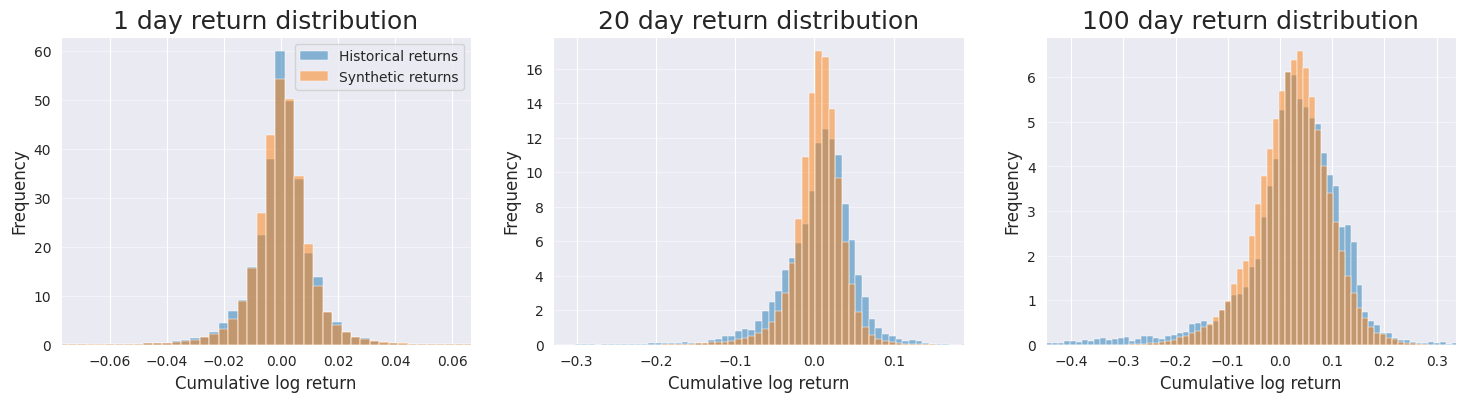

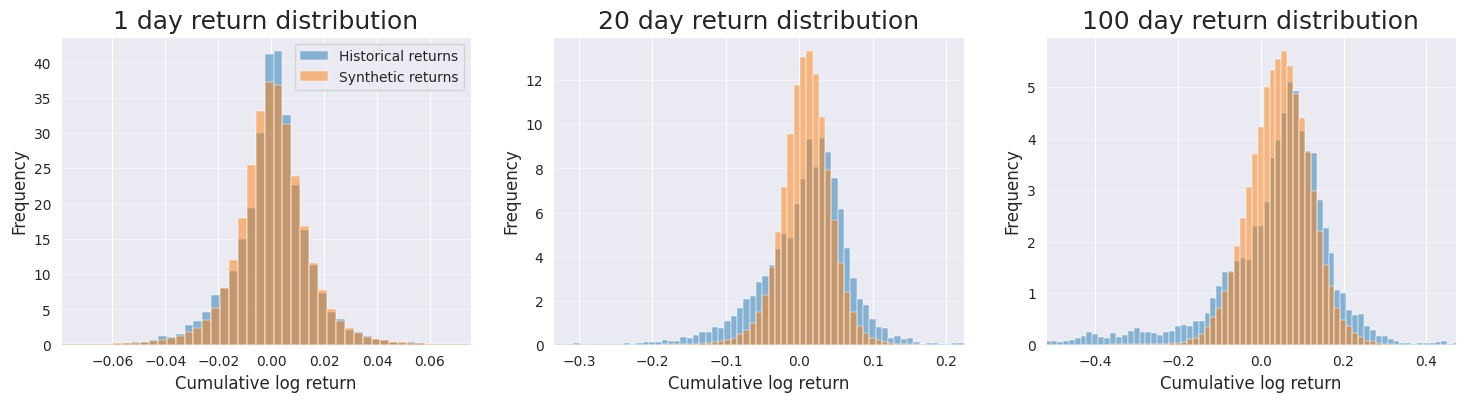

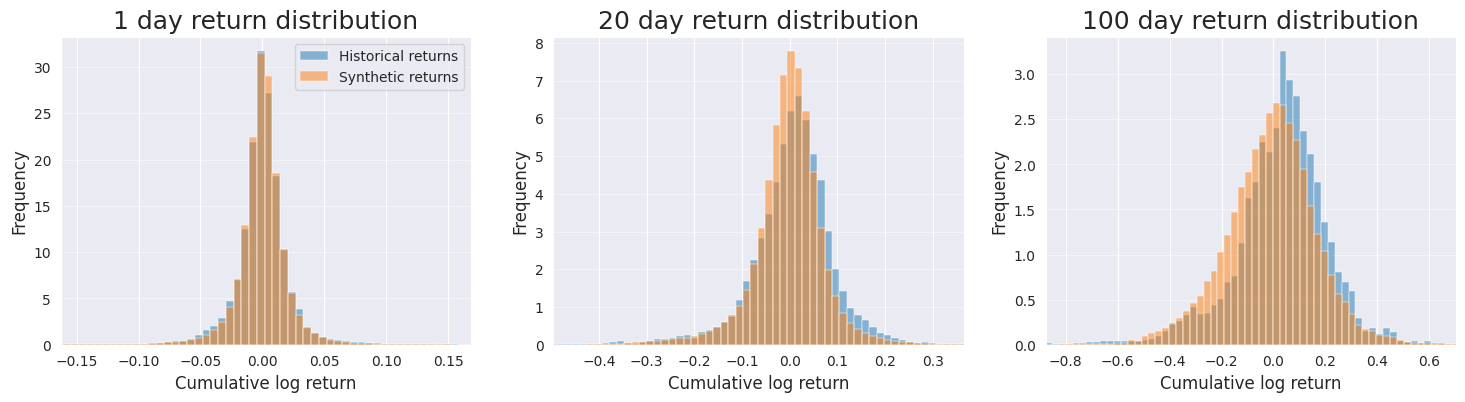

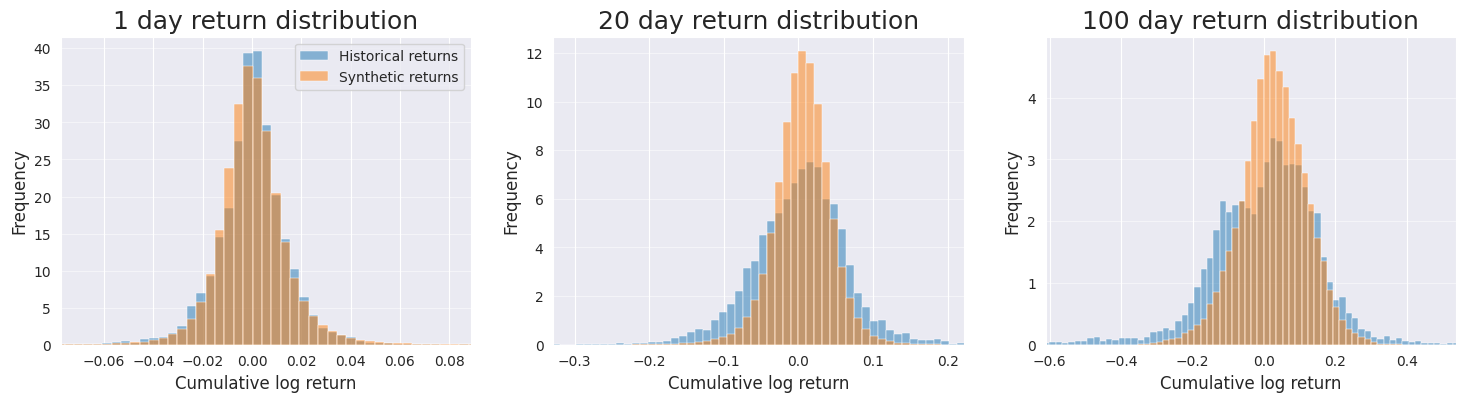

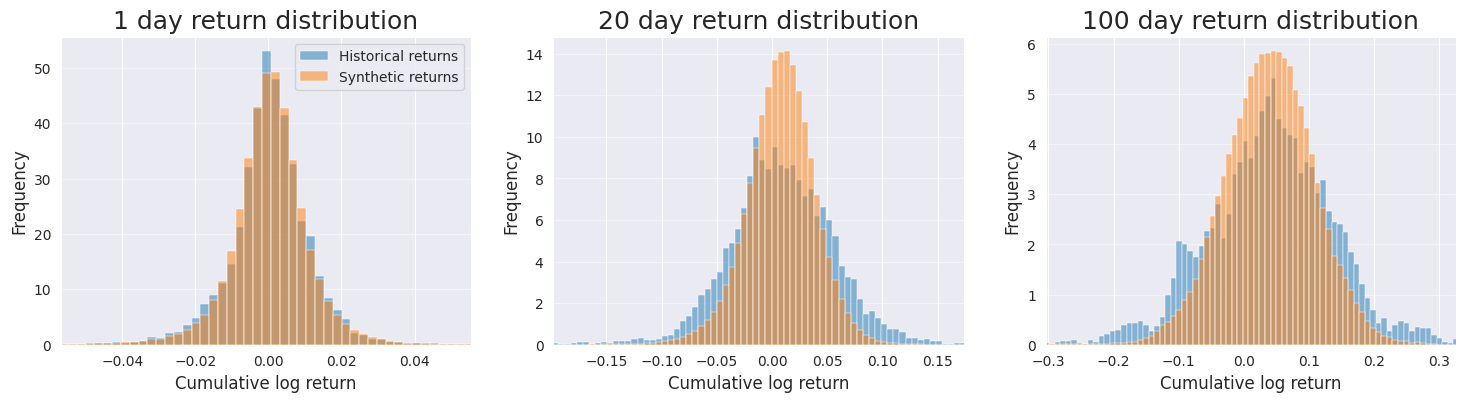

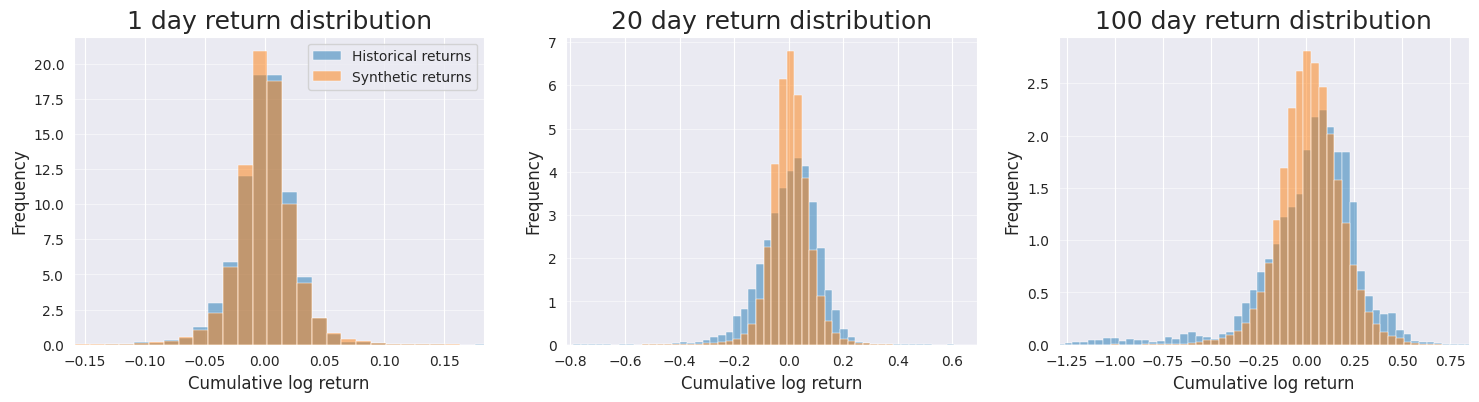

{'EMD':               EMD 0   EMD 1   EMD 2   EMD 3   EMD 4   EMD 5  EMD_avg
 window size                                                         
 1            0.0004  0.0006  0.0011  0.0007  0.0003  0.0011   0.0007
 5            0.0052  0.0082  0.0080  0.0091  0.0061  0.0128   0.0082
 20           0.0114  0.0189  0.0134  0.0191  0.0128  0.0306   0.0177
 100          0.0171  0.0385  0.0419  0.0398  0.0201  0.0680   0.0376,
 'KL':                KL 0    KL 1    KL 2    KL 3    KL 4    KL 5
 window size                                                
 1            0.0078  0.0117  0.0058  0.0132  0.0077  0.0079
 5            0.0937  0.1462  0.0655  0.1715  0.1282  0.1127
 20           0.1419  0.2913  0.0473  0.2178  0.1984  0.1802
 100          0.2937  0.5686  0.0820  0.3682  0.1578  0.2492,
 'JS':                JS 0    JS 1    JS 2    JS 3    JS 4    JS 5
 window size                                                
 1            0.0442  0.0541  0.0381  0.0578  0.0443  0.0445
 5        

In [11]:
""" Visualize the distribution of the real and fake data """
fake_list = [fake_data[:, i, :] for i in range(fake_data.shape[1])]
real_list = [real_data[:, i, :] for i in range(real_data.shape[1])]

# Plot the distribution of the real and fake data
windows = [1, 20, 100]
for j in range(config.n_vars):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))  

    for i in range(len(windows)):
        col = i

        real_dist = rolling_window(real_list[j].T, windows[i]).sum(axis=1).ravel()
        fake_dist = rolling_window(fake_list[j].T, windows[i]).sum(axis=1).ravel()        
        
        min_val = real_dist.min()
        max_val = real_dist.max()
        
        bins = np.linspace(min_val, max_val, 81)  
        
        sns.histplot(real_dist, bins=bins, kde=False, ax=axs[col], color='tab:blue', alpha=0.5, stat='density')
        sns.histplot(fake_dist, bins=bins, kde=False, ax=axs[col], color='tab:orange', alpha=0.5, stat='density')

        axs[col].set_xlim(*np.quantile(real_dist, [0.001, .999]))
        
        axs[col].set_title('{} day return distribution'.format(windows[i]), size=18)
        axs[col].yaxis.grid(True, alpha=0.5)
        axs[col].set_xlabel('Cumulative log return', fontsize=12)
        axs[col].set_ylabel('Frequency', fontsize=12)

    axs[0].legend(['Historical returns', 'Synthetic returns'])

plt.show()

def calculate_distribution_scores(real, fake, num_G, windows):
    scores = {
        'EMD': np.zeros((num_G, len(windows))),
        'KL': np.zeros((num_G, len(windows))),
        'JS': np.zeros((num_G, len(windows))),
        'KS': np.zeros((num_G, len(windows)))
    }

    for i in range(num_G):
        for j in range(len(windows)):
            real_dist = rolling_window(real[i].T, windows[j]).sum(axis=1).ravel()
            fake_dist = rolling_window(fake[i].T, windows[j]).sum(axis=1).ravel()
            
            np.random.shuffle(real_dist)
            np.random.shuffle(fake_dist)
            
            # Calculate EMD
            scores['EMD'][i, j] = wasserstein_distance(real_dist, fake_dist)
            
            # Calculate KS Statistic
            scores['KS'][i, j], _ = ks_2samp(real_dist, fake_dist)                                    
            
            # Create histograms to estimate the probability distributions
            real_hist, bin_edges = np.histogram(real_dist, bins=100, density=True)
            fake_hist, _ = np.histogram(fake_dist, bins=bin_edges, density=True)
            
            # Normalize the histograms to get probability distributions
            real_prob = real_hist / np.sum(real_hist)
            fake_prob = fake_hist / np.sum(fake_hist)
            
            # Calculate KL Divergence
            kl_divergence = entropy(real_prob + 1e-10, fake_prob + 1e-10)
            scores['KL'][i, j] = kl_divergence

            # Calculate JS Divergence
            js_divergence = jensenshannon(real_prob + 1e-10, fake_prob + 1e-10)
            scores['JS'][i, j] = js_divergence
                
    df_scores = {}
    for metric, data in scores.items():
        data = np.round(data, decimals=4)
        df_scores[metric] = pd.DataFrame(data.T, index=windows, columns=[f'{metric} {i}' for i in range(num_G)])
        
    emd_avg = np.mean(scores['EMD'], axis=0)
    df_scores['EMD']['EMD_avg'] = np.round(emd_avg, decimals=4)
    
    return df_scores

# Calculate the distribution scores
windows = pd.Series([1, 5, 20, 100], name='window size')

results_emd = calculate_distribution_scores(real_list, fake_list, config.n_vars, windows)
results_emd

In [17]:
from scipy.stats import skew, kurtosis

def calculate_skew_kurt_diff(fake_list, real_list):
    results = []
    skewness_diffs = []
    kurtosis_diffs = []
    
    for asset_idx in range(len(real_list)):
        fake_data = fake_list[asset_idx]
        real_data = real_list[asset_idx]

        # 각 샘플에 대해 skewness와 kurtosis를 계산하고 평균을 구합니다.
        fake_skewness = np.mean([skew(sample) for sample in fake_data])
        fake_kurtosis = np.mean([kurtosis(sample, fisher=False) for sample in fake_data])
        print(fake_kurtosis)
        real_skewness = np.mean([skew(sample) for sample in real_data])
        real_kurtosis = np.mean([kurtosis(sample, fisher=False) for sample in real_data])
        print(real_kurtosis)

        # skewness와 kurtosis의 차이 계산
        skewness_diff = np.abs(real_skewness - fake_skewness)
        kurtosis_diff = np.abs(real_kurtosis - fake_kurtosis)

        # 소수점 자릿수 제한
        skewness_diff = round(skewness_diff, 4)
        kurtosis_diff = round(kurtosis_diff, 4)

        results.append((skewness_diff, kurtosis_diff))
        skewness_diffs.append(skewness_diff)
        kurtosis_diffs.append(kurtosis_diff)

        print(f'Asset {asset_idx + 1} Skewness Difference: {skewness_diff}')
        print(f'Asset {asset_idx + 1} Kurtosis Difference: {kurtosis_diff}')
        
    # 평균 계산 수정
    avg_skewness_diff = round(np.mean(skewness_diffs), 4)
    avg_kurtosis_diff = round(np.mean(kurtosis_diffs), 4)

    print(f"\n[평균] Skewness Difference: {avg_skewness_diff}")
    print(f"[평균] Kurtosis Difference: {avg_kurtosis_diff}")
    
    return results

calculate_skew_kurt_diff(fake_list, real_list)

13.209816658664622


/opt/conda/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1076: RuntimeWarning: underflow encountered in square
  s = s**2


4.620270305097471
Asset 1 Skewness Difference: 0.5016
Asset 1 Kurtosis Difference: 8.5895
8.690088897035059
4.0664397664680845
Asset 2 Skewness Difference: 0.1591
Asset 2 Kurtosis Difference: 4.6236
17.772319866769987
5.085108038284641
Asset 3 Skewness Difference: 0.8041
Asset 3 Kurtosis Difference: 12.6872
8.920073757057809
4.286174638436822
Asset 4 Skewness Difference: 0.2589
Asset 4 Kurtosis Difference: 4.6339
8.868820005633957
5.492471030126201
Asset 5 Skewness Difference: 0.3107
Asset 5 Kurtosis Difference: 3.3763
12.115698451542706
4.637490171169042
Asset 6 Skewness Difference: 0.1867
Asset 6 Kurtosis Difference: 7.4782

[평균] Skewness Difference: 0.3702
[평균] Kurtosis Difference: 6.8981


[(0.5016, 8.5895),
 (0.1591, 4.6236),
 (0.8041, 12.6872),
 (0.2589, 4.6339),
 (0.3107, 3.3763),
 (0.1867, 7.4782)]

0


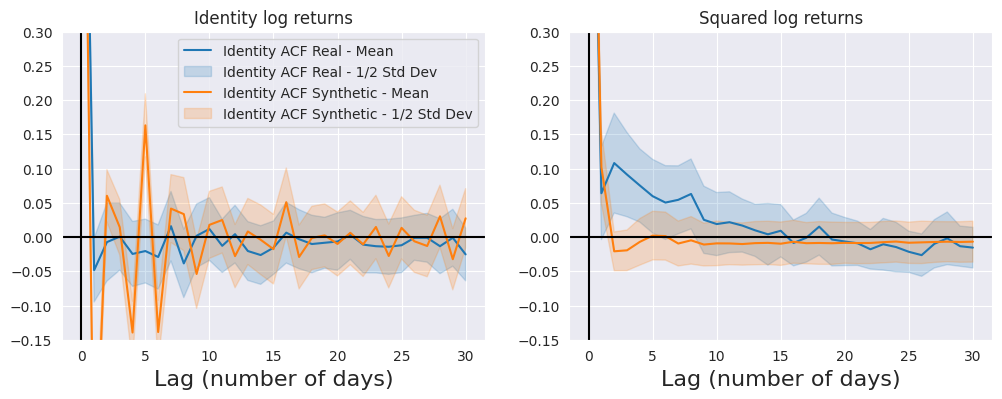

1


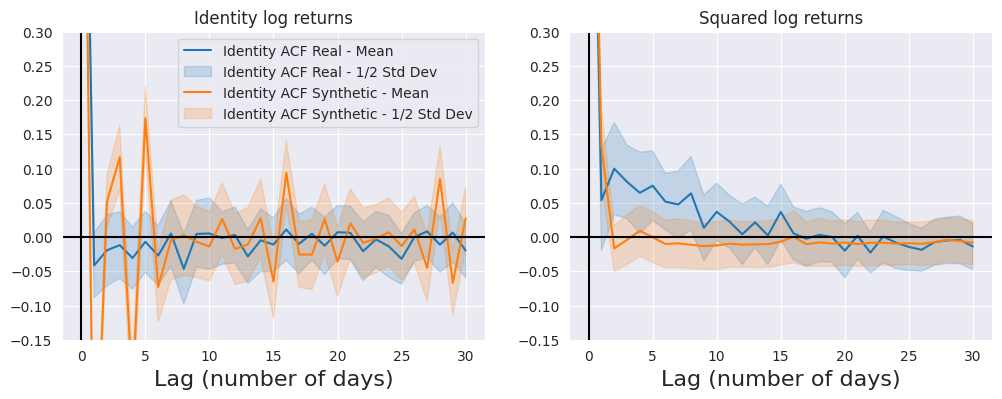

2


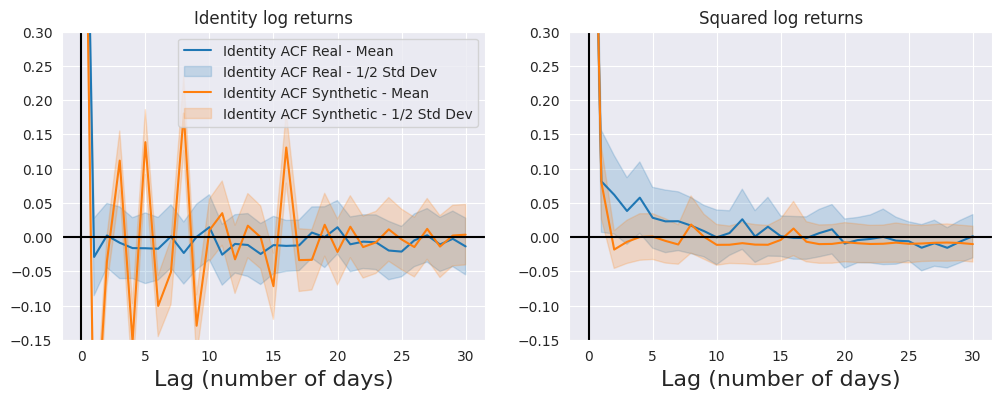

3


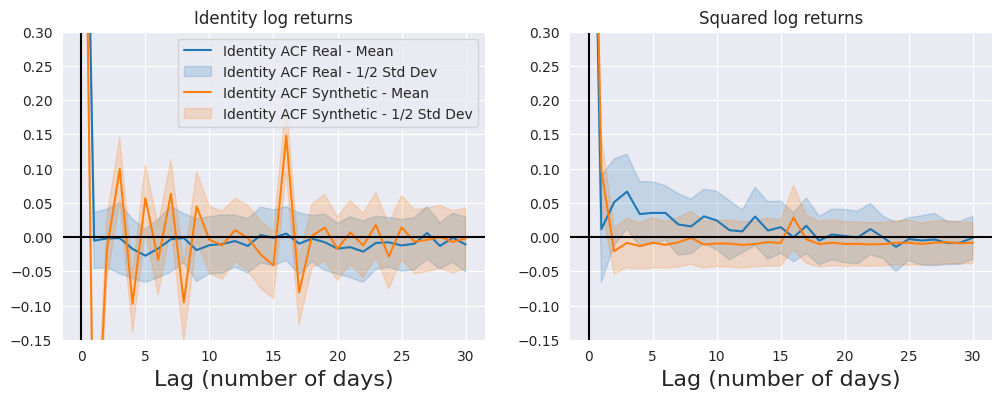

4


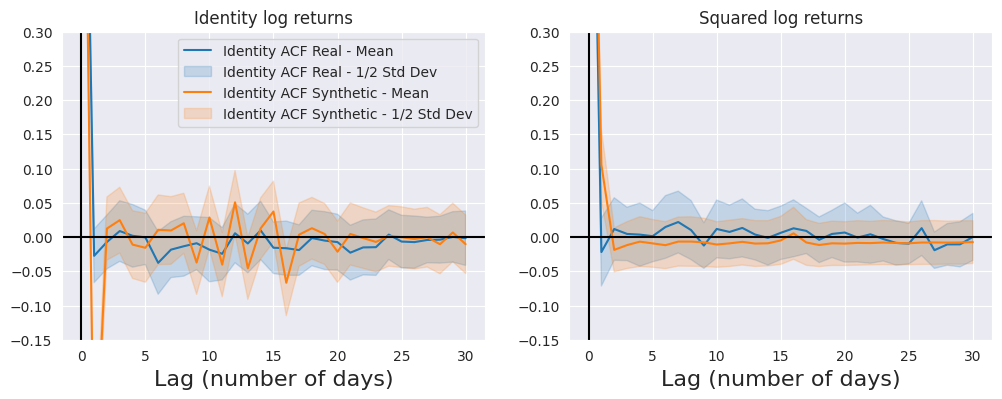

5


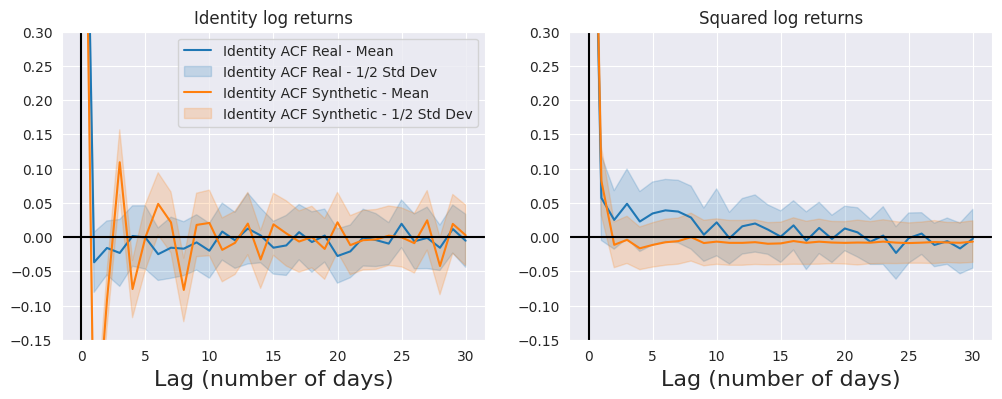

=== ACF Scores (per group) ===
Group 1:
  - Identity log returns: loss=0.0069
  - Absolute log returns: loss=0.003
  - Squared log returns: loss=0.0019
Group 2:
  - Identity log returns: loss=0.0097
  - Absolute log returns: loss=0.0028
  - Squared log returns: loss=0.0018
Group 3:
  - Identity log returns: loss=0.0084
  - Absolute log returns: loss=0.0012
  - Squared log returns: loss=0.0006
Group 4:
  - Identity log returns: loss=0.0075
  - Absolute log returns: loss=0.0021
  - Squared log returns: loss=0.0011
Group 5:
  - Identity log returns: loss=0.0047
  - Absolute log returns: loss=0.0015
  - Squared log returns: loss=0.0007
Group 6:
  - Identity log returns: loss=0.0045
  - Absolute log returns: loss=0.0012
  - Squared log returns: loss=0.0006

=== Overall Average Scores ===
Identity log returns: mean of means=0.007
Absolute log returns: mean of means=0.002
Squared log returns: mean of means=0.0011


In [13]:
""" visualizing acf plots """
def plot_acf_comparison(real_list, fake_list, n_vars, lags=30):    
    data_types = ['Identity', 'Squared']
    data_transforms = [lambda x: x, np.square]  
    titles = ['Identity log returns', 'Squared log returns']

    for i in range(n_vars):
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))  
        print(i)
        for ax, data_type, transform, title in zip(axs, data_types, data_transforms, titles):
            
            transformed_real = transform(real_list[i])
            transformed_fake = transform(fake_list[i])
            
            acf_real = np.array([acf(ts, nlags=lags) for ts in transformed_real])
            acf_fake = np.array([acf(ts, nlags=lags) for ts in transformed_fake])
            
            mean_real = np.mean(acf_real, axis=0)
            std_real = np.std(acf_real, axis=0)
            mean_fake = np.mean(acf_fake, axis=0)
            std_fake = np.std(acf_fake, axis=0)
                        
            ax.plot(mean_real, label=f'{data_type} ACF Real - Mean', color='tab:blue')
            ax.fill_between(range(lags+1), mean_real - 0.5*std_real, mean_real + 0.5*std_real, color='tab:blue', alpha=0.2,
                            label=f'{data_type} ACF Real - 1/2 Std Dev')        
            ax.plot(mean_fake, label=f'{data_type} ACF Synthetic - Mean', color='tab:orange')
            ax.fill_between(range(lags+1), mean_fake - 0.5*std_fake, mean_fake + 0.5*std_fake, color='tab:orange', alpha=0.2,
                            label=f'{data_type} ACF Synthetic - 1/2 Std Dev')
            
            ax.set_ylim(-0.15, 0.3)
            ax.set_title(title)
            ax.grid(True)
            ax.axhline(y=0, color='k')
            ax.axvline(x=0, color='k')
            ax.set_xlabel('Lag (number of days)', fontsize=16)
            
        axs[0].legend()

        plt.show()

plot_acf_comparison(real_list, fake_list, config.n_vars, lags=30)

import numpy as np
from statsmodels.tsa.stattools import acf

def calculate_acf_score_mean_vs_mean_no_std(
    real_list,
    fake_list,
    lags=30,
    loss_type='mse'
):
    """
    real_list[i], fake_list[i] 각각 하나의 "그룹" 또는 "자산" 집합이라고 가정
    각 real_list[i]에는 (n_real_samples_i, ) 형태의 시계열이 여러 개 들어있다고 보고,
    fake_list[i]에도 여러 시계열이 들어있다고 봄.

    -> Real 평균 ACF vs. Fake 평균 ACF만을 비교하여 MSE, MAE 등을 계산하는 버전.
       표준편차( std )는 따로 계산하지 않음.
    """
    # 변환 함수 정의
    data_transforms = [lambda x: x, np.abs, np.square]  
    titles = ['Identity log returns', 'Absolute log returns', 'Squared log returns']

    acf_scores = {}  # 그룹별 결과 저장
    # 최종적으로 transform별 "평균 점수(mean of means)"를 계산할 목적
    avg_scores_per_transform = {title: [] for title in titles}

    n_vars = len(real_list)
    for group_idx in range(n_vars):
        group_scores = {}  # 이 그룹에 대한 transform별 점수(스칼라값)

        for transform, title in zip(data_transforms, titles):
            # (1) Real / Fake 데이터 변환
            transformed_real = transform(real_list[group_idx])
            transformed_fake = transform(fake_list[group_idx])
            
            # (2) 각 샘플별 ACF 계산
            acf_real = np.array([acf(ts, nlags=lags) for ts in transformed_real])  
            acf_fake = np.array([acf(ts, nlags=lags) for ts in transformed_fake])  

            # (3) Real, Fake 각각의 평균 ACF 계산
            mean_acf_real = np.mean(acf_real, axis=0)  # shape=(lags+1,)
            mean_acf_fake = np.mean(acf_fake, axis=0)  # shape=(lags+1,)

            # (4) Real 평균 ACF vs. Fake 평균 ACF 차이
            diff = mean_acf_fake - mean_acf_real

            # (5) loss_type에 따라 계산 (MSE or MAE 등)
            if loss_type == 'mse':
                val = np.mean(diff**2)
            elif loss_type == 'mae':
                val = np.mean(np.abs(diff))
            else:
                raise ValueError(f"Unknown loss_type: {loss_type}")

            # (6) 표준편차는 사용하지 않으므로, 결과는 스칼라 val만
            group_scores[title] = round(val, 4)

            # (7) 전체 평균 계산을 위해 저장
            avg_scores_per_transform[title].append(val)

        # 해당 그룹에 대한 transform별 점수 기록
        acf_scores[f"Group {group_idx+1}"] = group_scores
    
    # 모든 그룹에 대한 “평균의 평균”(mean of means) 계산
    overall_average_scores = {}
    for title in titles:
        mean_of_means = np.mean(avg_scores_per_transform[title])
        overall_average_scores[title] = round(mean_of_means, 4)

    return acf_scores, overall_average_scores


# 사용 예시
lags = 30
loss_type = 'mse'  # 'mse', 'mae' 등

acf_scores, overall_avg_scores = calculate_acf_score_mean_vs_mean_no_std(
    real_list, 
    fake_list, 
    lags=lags, 
    loss_type=loss_type
)

print("=== ACF Scores (per group) ===")
for group_name, transform_scores in acf_scores.items():
    print(f"{group_name}:")
    for transform_title, val in transform_scores.items():
        print(f"  - {transform_title}: loss={val}")

print("\n=== Overall Average Scores ===")
for transform_title, mean_of_means in overall_avg_scores.items():
    print(f"{transform_title}: mean of means={mean_of_means}")


[Correlation Loss - MAE]
Loss: 0.061

[Correlation Loss - Frobenius]
Loss: 0.5195

[Correlation Loss - MSE]
Loss: 0.0075


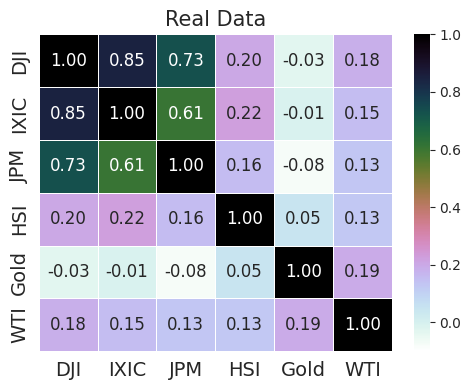

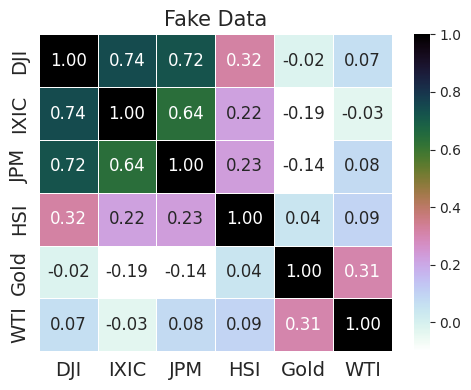

In [14]:
def correlation_mean(data):
    """
    각 샘플의 상관행렬을 계산한 후, 그 평균을 반환.
    
    Parameters:
        data (np.ndarray): shape = (num_samples, num_time_steps, num_features)
    
    Returns:
        mean_correlation_matrix (np.ndarray): shape = (num_features, num_features)
    """
    num_samples = data.shape[0]
    correlations = []

    for i in range(num_samples):
        sample = data[i]  # shape = (num_time_steps, num_features)
        corr_mat = np.corrcoef(sample, rowvar=False)
        correlations.append(corr_mat)

    mean_correlation_matrix = np.mean(correlations, axis=0)  
    return mean_correlation_matrix


def correlation_loss(real_mean_corr, fake_mean_corr, loss_type='mse'):
    """
    Real과 Fake의 평균 상관행렬 간의 손실을 계산.
    
    Parameters:
        real_mean_corr (np.ndarray): Real 데이터의 평균 상관행렬
        fake_mean_corr (np.ndarray): Fake 데이터의 평균 상관행렬
        loss_type (str): 'mse', 'mae', 'frobenius' 중 선택
    
    Returns:
        loss (float): 지정된 손실 타입에 따른 손실 값 (소수점 4자리로 반올림)
    """
    diff = fake_mean_corr - real_mean_corr

    if loss_type == 'mse':
        loss_val = np.mean(diff**2)
    elif loss_type == 'mae':
        loss_val = np.mean(np.abs(diff))
    elif loss_type == 'frobenius':            
        loss_val = np.linalg.norm(diff, ord='fro')
    else:
        raise ValueError(f"Unsupported loss_type: {loss_type}")

    return round(loss_val, 4)

# 상관행렬 계산을 위해 데이터 전치 (shape: (num_samples, num_time_steps, num_features))
real_mean_corr = correlation_mean(np.transpose(real_data, (0, 2, 1)))
fake_mean_corr = correlation_mean(np.transpose(fake_data, (0, 2, 1)))

# 손실 계산
loss_mae = correlation_loss(real_mean_corr, fake_mean_corr, loss_type='mae')
loss_frob = correlation_loss(real_mean_corr, fake_mean_corr, loss_type='frobenius')
loss_mse = correlation_loss(real_mean_corr, fake_mean_corr, loss_type='mse')

# 결과 출력
print("[Correlation Loss - MAE]")
print(f"Loss: {loss_mae}")

print("\n[Correlation Loss - Frobenius]")
print(f"Loss: {loss_frob}")

print("\n[Correlation Loss - MSE]")
print(f"Loss: {loss_mse}")


def plot_correlation_heatmap(correlation_matrix, title, feature_names):
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(correlation_matrix, annot=True, cmap='cubehelix_r', linewidths=.5, ax=ax, fmt=".2f", annot_kws={"size": 12}, vmin=-0.1, vmax=1)
    
    # 축 이름 설정
    ax.set_xticklabels(feature_names, fontsize=12)
    ax.set_yticklabels(feature_names, fontsize=12)
    
    # 제목 및 시각적 요소
    ax.set_title(title, fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.tight_layout()
    plt.show()

feature_names = ['DJI', 'IXIC', 'JPM', 'HSI', 'Gold', 'WTI']
plot_correlation_heatmap(real_mean_corr, "Real Data", feature_names)
plot_correlation_heatmap(fake_mean_corr, "Fake Data", feature_names)


In [18]:
import numpy as np
from statsmodels.tsa.stattools import ccf

def ccf_single_sample(x, max_lag=10):
    """
    x: shape = (time_steps, features)
    - statsmodels.tsa.stattools.ccf(x[:, i], x[:, j])를 이용해
      i, j 모든 쌍에 대해 lag=0..max_lag 범위의 cross-correlation을 구한다.
    - 결과를 3D 배열 (features, features, max_lag+1)에 저장하여 반환.

    Returns
    -------
    cc_matrix: np.ndarray
      shape = (num_features, num_features, max_lag+1)
      cc_matrix[i, j, k] = ccf 결과에서 lag=k인 상관계수
    """
    time_steps, num_features = x.shape
    cc_matrix = np.zeros((num_features, num_features, max_lag+1), dtype=float)

    for i in range(num_features):
        for j in range(num_features):
            # statsmodels ccf: lag >= 0 에 대한 상관계수
            c_array = ccf(x[:, i], x[:, j], adjusted=False)
            # lag=0 ~ max_lag만 추출
            c_array = c_array[:(max_lag+1)]
            # ccf 함수는 무한대로 확장될 수 있으므로, 필요한 max_lag+1까지만 자르기
            if len(c_array) < (max_lag+1):
                # 부족한 경우 0으로 채우기
                c_array = np.pad(c_array, (0, max_lag+1 - len(c_array)), 'constant')
            cc_matrix[i, j, :] = c_array

    return cc_matrix

def ccf_mean(data, max_lag=10):
    """
    data: shape = (num_samples, time_steps, features)

    각 샘플마다 ccf_single_sample -> (features, features, max_lag+1)
    모든 샘플에 대해 평균낸 결과를 반환.

    Returns
    -------
    mean_ccf: np.ndarray
      shape = (num_features, num_features, max_lag+1)
    """
    num_samples, time_steps, num_features = data.shape

    # 모든 샘플의 CCF 결과를 쌓아두기
    all_cc = np.zeros((num_samples, num_features, num_features, max_lag+1), dtype=float)

    for s_idx in range(num_samples):
        cc_matrix = ccf_single_sample(data[s_idx], max_lag=max_lag)
        all_cc[s_idx] = cc_matrix  # shape=(features, features, max_lag+1)

    # 샘플 차원에 대해 평균
    mean_ccf = all_cc.mean(axis=0)  # shape=(features, features, max_lag+1)
    return mean_ccf

def ccf_loss_mean_vs_mean(real_mean_ccf, fake_mean_ccf, loss_type='mse'):
    """
    - real_mean_ccf: shape = (features, features, max_lag+1)
      Real 데이터의 평균 CCF 행렬
    - fake_mean_ccf: shape = (features, features, max_lag+1)
      Fake 데이터의 평균 CCF 행렬
    - loss_type: 'mse', 'mae', 'frobenius' 중 선택

    returns: loss (float), 소수점 4자리로 반올림
    """
    # 두 평균 CCF 행렬의 차이
    diff = fake_mean_ccf - real_mean_ccf

    # 손실 계산
    if loss_type == 'mse':
        loss_val = np.mean(diff**2)
    elif loss_type == 'mae':
        loss_val = np.mean(np.abs(diff))
    elif loss_type == 'frobenius':
        # 3D 배열에 대한 Frobenius norm
        loss_val = np.linalg.norm(diff)
    else:
        raise ValueError(f"Unsupported loss_type: {loss_type}")

    return round(loss_val, 4)

# 사용 예시
max_lag = 10

# CCF 계산을 위해 데이터 전치 (shape: (num_samples, time_steps, num_features))
# 기존에 사용된 np.transpose(real_data, (0, 2, 1))은 이미 올바른 형상으로 가정
real_mean_ccf = ccf_mean(np.transpose(real_data, (0, 2, 1)), max_lag=max_lag)
fake_mean_ccf = ccf_mean(np.transpose(fake_data, (0, 2, 1)), max_lag=max_lag)

# 손실 계산
loss_mae = ccf_loss_mean_vs_mean(real_mean_ccf, fake_mean_ccf, loss_type='mae')
loss_frob = ccf_loss_mean_vs_mean(real_mean_ccf, fake_mean_ccf, loss_type='frobenius')
loss_mse = ccf_loss_mean_vs_mean(real_mean_ccf, fake_mean_ccf, loss_type='mse')

# 결과 출력
print("[Partial CCF Loss - MAE]")
print(f"Loss: {loss_mae}")

print("\n[Partial CCF Loss - Frobenius]")
print(f"Loss: {loss_frob}")

print("\n[Partial CCF Loss - MSE]")
print(f"Loss: {loss_mse}")


[Partial CCF Loss - MAE]
Loss: 0.0755

[Partial CCF Loss - Frobenius]
Loss: 2.1359

[Partial CCF Loss - MSE]
Loss: 0.0115


In [16]:
def leverage_effect_loss_mean_vs_mean(real_list, fake_list, lags=30, loss_type='mse'):
    """
    Real 데이터의 평균 레버리지 효과와 Fake 데이터의 평균 레버리지 효과를 비교하여 손실을 계산.

    Parameters:
        real_list (list of np.ndarray): 각 그룹별 Real 데이터. 각 요소는 shape=(n_real_samples, time_length)
        fake_list (list of np.ndarray): 각 그룹별 Fake 데이터. 각 요소는 shape=(n_fake_samples, time_length)
        lags (int): 최대 시차 (tau) 값
        loss_type (str): 손실 함수의 종류 ('mse', 'mae', 'fro')

    Returns:
        leverage_scores (dict): 그룹별 손실 값 저장
        overall_mean (float): 모든 그룹의 평균 손실
    """

    def leverage_effect(ts, tau):
        """
        레버리지 효과 계산:
        Corr(r_t, r_(t+tau)^2)
        """
        rt = ts[:-tau]            # 뒤에서 tau 개 제외
        rt_squared = ts[tau:]**2  # 앞에서 tau 개 제외한 뒤 제곱
        return np.corrcoef(rt, rt_squared)[0, 1]  # 상관계수

    n_vars = len(real_list)
    leverage_scores = {}     # 그룹별 손실 값 저장
    all_group_losses = []    # 모든 그룹의 손실 값을 모아 전체 평균 손실 계산

    for i in range(n_vars):
        real_data = real_list[i]  # shape=(n_real_samples, time_length)
        fake_data = fake_list[i]  # shape=(n_fake_samples, time_length)

        # (1) Real 각 샘플의 레버리지 효과 (tau=1부터 lags까지)
        real_leverage_effects = np.array([
            [leverage_effect(ts, tau) for tau in range(1, lags+1)]
            for ts in real_data
        ])  # shape = (n_real_samples, lags)

        # (2) Fake 각 샘플의 레버리지 효과
        fake_leverage_effects = np.array([
            [leverage_effect(ts, tau) for tau in range(1, lags+1)]
            for ts in fake_data
        ])  # shape = (n_fake_samples, lags)

        # (3) Real의 평균 레버리지 효과 계산
        mean_real_leverage = np.mean(real_leverage_effects, axis=0)  # shape=(lags,)

        # (4) Fake의 평균 레버리지 효과 계산
        mean_fake_leverage = np.mean(fake_leverage_effects, axis=0)  # shape=(lags,)

        # (5) Real 평균과 Fake 평균 간의 차이 계산
        diff = mean_fake_leverage - mean_real_leverage

        # (6) loss_type에 따라 손실 계산
        if loss_type == 'mse':
            loss_val = np.mean(diff**2)
        elif loss_type == 'mae':
            loss_val = np.mean(np.abs(diff))
        elif loss_type == 'frobenius':
            loss_val = np.linalg.norm(diff)
        else:
            raise ValueError(f"Unsupported loss_type: {loss_type}")

        # (7) 손실 값 저장 (소수점 반올림은 최종 저장 시점에 적용)
        leverage_scores[f'Group {i+1}'] = loss_val
        all_group_losses.append(loss_val)

        # (8) 그룹별 손실 출력 (소수점 반올림)
        print(f"[Group {i+1}] Leverage Loss ({loss_type.upper()}) => {loss_val:.4f}")

    # (9) 전체 그룹의 평균 손실 계산
    overall_mean = np.mean(all_group_losses)
    print(f"\n[Overall] Leverage Loss ({loss_type.upper()}) => {overall_mean:.4f}")

    # (10) 최종 결과를 소수점 4자리로 반올림하여 저장
    for group in leverage_scores:
        leverage_scores[group] = round(leverage_scores[group], 4)
    overall_mean = round(overall_mean, 4)

    return leverage_scores, overall_mean

# 예시 사용

# 손실 계산 (예: 'mse', 'mae', 'frobenius' 중 선택)
loss_type = 'mse'  # 'mse', 'mae', 'frobenius'

leverage_scores, overall_mean = leverage_effect_loss_mean_vs_mean(
    real_list, 
    fake_list, 
    lags=lags, 
    loss_type=loss_type
)

# 최종 결과 출력
print("\n=== Leverage Effect Loss (Mean vs. Mean) ===")
for group, loss in leverage_scores.items():
    print(f"{group}: {loss}")
print(f"Overall Mean Loss: {overall_mean}")

[Group 1] Leverage Loss (MSE) => 0.0017
[Group 2] Leverage Loss (MSE) => 0.0016
[Group 3] Leverage Loss (MSE) => 0.0007


KeyboardInterrupt: 

### Synthetic data generation

### Model evaluation

We compute the performance of our model by first generating the price process, apply the prespecified trading strategies and compare the resulting PnL process using the real and fake data.

In [32]:
from src.evaluation.strategies import log_return_to_price

eval_size = real_data.shape[0]
fake_data_torch = torch.from_numpy(fake_data).float().transpose(1, 2)
real_data_torch = torch.from_numpy(real_data).float().transpose(1, 2)

fake_prices = log_return_to_price(fake_data_torch[:eval_size], train_init_price[:eval_size])
real_prices = log_return_to_price(real_data_torch[:eval_size], train_init_price[:eval_size])

In [ ]:
config_dir = 'src/evaluation/config.yaml'
with open(config_dir) as file:
    eval_config = ml_collections.ConfigDict(yaml.safe_load(file))
    
print(fake_data_torch.shape, real_data_torch.shape, test_init_price.shape)

all_positive = (fake_prices > 0).all()
if not all_positive:
    raise ValueError("Sanity Check Failed: Some fake prices are not positive.")

res_dict = {"var_mean" : 0., "es_mean": 0., "max_drawback_mean": 0., "cumulative_pnl_mean": 0.,}

# Do final evaluation
num_strat = 4

with torch.no_grad():
    for strat_name in ['equal_weight', 'mean_reversion', 'trend_following', 'vol_trading']:
        subres_dict = full_evaluation(fake_prices, real_prices, eval_config, strat_name = strat_name)
        filtered_means = {k: round(v, 4) for k, v in subres_dict.items() if '_mean' in k}
        print(strat_name, filtered_means)
        for k in res_dict:
            res_dict[k] += subres_dict[k] / num_strat 
for k, v in res_dict.items():
    print(k, v)

# Evaluation Phase 2

Prepare real and synthetic data for evaluations.

In [37]:
# Load the dataset
from src.evaluations.plot import *
from src.evaluations.evaluations import *
val_set = TensorDataset(real_data_torch)
fake_set = TensorDataset(fake_data_torch)

fake_test_dl = DataLoader(
    fake_set,
    batch_size=config.batch_size,
    shuffle=True
)
real_test_dl = DataLoader(
    val_set,
    batch_size=config.batch_size,
    shuffle=True
)

x_real, x_fake = loader_to_tensor(real_test_dl), loader_to_tensor(fake_test_dl)

In [ ]:
print(next(iter(real_test_dl))[0].shape)
print(next(iter(fake_test_dl))[0].shape)

# Visualization

### Samples plot

In [ ]:
plot_samples(real_test_dl, fake_test_dl, config, plot_show = True)

# Stylised facts

### Histogram

In [ ]:
#fig = plot_hists_marginals(x_real, x_fake)

The plot above illustrate the marginal distribution comparisons across various time steps.
Essentially we can quantify this by the marginal distribution loss: 

In [ ]:
# Marginal_loss = to_numpy(HistoLoss(x_real[:, 1:, :], n_bins=50, name='marginal_distribution')(x_fake[:, 1:, :]))
# print('Marginal Loss = ', Marginal_loss)

### Autocorrelation

In [ ]:
# name = 'Our Model'
# compare_acf_matrix(real_test_dl, fake_test_dl, config)

The above plots demonstrated the quality of the generated sample in terms of autocorrelation. Correspondingly, we have the loss

In [ ]:
# acf_loss = to_numpy(ACFLoss(x_real, name='auto_correlation')(x_fake))
# print('autocorrelation Loss = ', acf_loss)

In [ ]:
# # CrossCorrelLoss 인스턴스 생성 시 name 인수를 추가
# cross_corr_loss = CrossCorrelLoss(x_real, max_lag=64, name="cross_correlation")

# # 생성 데이터와 비교하여 손실 계산
# loss_value = cross_corr_loss.compute(x_fake)
# print('Cross-correlation Loss = ', loss_value)


In [ ]:
# # CovLoss 인스턴스 생성
# cov_loss = CovLoss(x_real, name="covariance_loss")

# # 생성 데이터와 비교하여 손실 계산
# loss_value = cov_loss.compute(x_fake)
# print('Covariance Loss = ', loss_value)


### T-sne

In [ ]:
fake_prices_set = TensorDataset(fake_prices)
real_prices_set = TensorDataset(real_prices)

fake_prices_dl = DataLoader(
    fake_prices_set,
    batch_size=config.batch_size,
    shuffle=True
)
real_prices_dl = DataLoader(
    real_prices_set,
    batch_size=config.batch_size,
    shuffle=True
)

tsne_plot(real_prices_dl, fake_prices_dl, config, plot_show =True)